# SEGMENTACION MEDIANTE ensamble de 3 U-NET+
TL (Transfer Learning)
* A) UNET+VGG16: TL VGG16 y Drop out 0.5 y regulac L2
* B) UNET+Resnet50: TL Resnet50
* C) UNET+Resnet152: TL Resnet152

Entrenados con función de pérdida **dice_loss**  

  dice_score = (2.0 * intersection + smooth) / (suma + smooth)

   
  dice_loss = 1.0 - dice_score

  dode smooth= 1 o 1e-5 ( 1 para VGG16 y Resnet50, 1e-5 para Resnet 152)


Aumentación A: 2 Traslaciones (i=-4,4, j=-4,4) y 4Flip (493*4*2=3940 imágenes)

Aumentación B:  5 Traslaciones (i=0, j=-4,-2,0,2,4) y 4Flip (493*4*5=9860 imágenes)

Aumentación C:  Traslaciones ( i=-4,4, j=-4,0.4) y 4Flip (493*4*6 = 11832 imágenes)


## Content Drive

In [ ]:
# Este comando es para leer los archivos directamente desde Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## path modelo e imágenes

In [ ]:
carpeta_modelo='ensamble_final_prueba_mala/'
carpeta_modelo1='VGG16_prueba_mala/'
carpeta_modelo2='Resnet50/'
carpeta_modelo3='Resnet152/'
#carpeta_modelo1='VGG16_1/'
#carpeta_modelo2='VGG16_1/'
#carpeta_modelo3='VGG16_2/'
path_resultados='/content/drive/MyDrive/Proyecto_Sadosky/modelo_final/resultados/'
path_resultados = "/content/drive/MyDrive/Sadosky_EcoDoppler/Investigación/Procesamiento/modelo_final/resultados/"
path_modelo=path_resultados+carpeta_modelo
path_modelo1=path_resultados+carpeta_modelo1
path_modelo2=path_resultados+carpeta_modelo2
path_modelo3=path_resultados+carpeta_modelo3

In [ ]:
path_train = "/content/drive/MyDrive/Proyecto_Sadosky/base_final/clean_database/train"
path_test = "/content/drive/MyDrive/Proyecto_Sadosky/base_final/clean_database/test"

In [ ]:
path_train = "/content/drive/MyDrive/Sadosky_EcoDoppler/Investigación/Procesamiento/base_final/clean_database/train"
path_test = "/content/drive/MyDrive/Sadosky_EcoDoppler/Investigación/Procesamiento/base_final/clean_database/test"

##  Codigo

In [ ]:
## Imports
import os
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras


## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Metricas para medir el desempeno de la red

In [ ]:
def jacard_coef_np(y_true, y_pred):
  y_true=y_true.astype('float32')
  y_pred=y_pred.astype('float32')
  intersection = np.sum(y_true * y_pred)
  return (intersection + 1.0) / (np.sum(y_true) + np.sum(y_pred) - intersection + 1.0)

In [ ]:
def dice_coef_np(y_true, y_pred):
  y_true=y_true.astype('float32')
  y_pred=y_pred.astype('float32')
  intersection = np.sum(y_true * y_pred)
  return (2*intersection + 1.0) / (np.sum(y_true) + np.sum(y_pred) + 1.0)

In [ ]:
import tensorflow.keras.backend as K

# intersection over union

def jacard_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = K.sum(y_true * y_pred)

    return (intersection + 1.0) / (K.sum(y_true) + K.sum(y_pred) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

In [ ]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-5):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_score = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = 1.0 - dice_score
    return dice_loss

In [ ]:
import tensorflow as tf
# este no funciona bien para smooth=1e-5, pasan cosas locas

def dice_loss_modif(y_true, y_pred, smooth=1): #smooth=1e-6
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_score = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = - dice_score+(tf.reduce_sum(y_pred)*smooth)**2
    return dice_loss

### Funciones para cálculo de Coeficientes, para test o Train

In [ ]:
def calc_coefs_Jaccard(Y,pred):
  dim=pred.shape
  #print(dim)
  #print(len(dim))
  n=dim[0]
  if len(dim)==3:
    Coefs=np.zeros(n)
    for item in range(n):
      Coefs[item]=jacard_coef_np(Y[item], pred[item])
  else:
    k=dim[3]
    Coefs=np.zeros((n,k))
    for item in range(n):
      for i in range(k):
        Coefs[item,i]=jacard_coef_np(Y[item], pred[item,:,:,i])

  return Coefs

In [ ]:
def calc_coefs_DICE(Y,pred):
  dim=pred.shape
  n=dim[0]
  #print(dim)
  #print(len(dim))
  if len(dim)==3:
    Coefs=np.zeros(n)
    for item in range(n):
      Coefs[item]=dice_coef_np(Y[item], pred[item])
  else:
    k=dim[3]
    Coefs=np.zeros((n,k))
    for item in range(n):
      for i in range(k):
        Coefs[item,i]=dice_coef_np(Y[item], pred[item,:,:,i])

  return Coefs

### comparación y visualización de imágenes

In [ ]:
def image_comparac(monocroma, etiqueta, red): #para un modelo
    # input: image and mask filepath and the index
    # output matplotlib images

    fig, ax = plt.subplots(1,4,figsize=(16,4)) #cambié para que se vean horizontales
    ax[0].imshow(monocroma, aspect='auto', cmap='gray')
    ax[0].set_title('monocroma')
    ax[1].imshow(etiqueta, aspect='auto', cmap='gray')
    ax[1].set_title('Ground Truth')
    ax[2].set_title('Predicción')
    ax[2].imshow(red, aspect='auto', cmap = 'gray')
    ax[3].imshow(monocroma, aspect='auto', cmap='gray')
    ax[3].imshow(etiqueta, cmap = 'Reds', aspect='auto', alpha = 0.4)
    ax[3].imshow(red, cmap = 'Blues', aspect='auto', alpha = 0.4)

In [ ]:
def model_comparac(monocroma, etiqueta, red1, red2,red3, red4, ensamble): #para 4 modelo y ensamble
    # input: image and mask filepath and the index
    # output matplotlib images

    fig, ax = plt.subplots(2,4,figsize=(16,8)) #cambié para que se vean horizontales
    ax[0,0].imshow(monocroma, aspect='auto', cmap='gray')
    ax[0,0].set_title('monocroma')
    ax[0,1].imshow(etiqueta, aspect='auto', cmap='gray')
    ax[0,1].set_title('Ground Truth')

    ax[0,2].set_title('Pred.'+carpeta_modelo1)
    ax[0,2].imshow(red1, aspect='auto', cmap = 'gray')
    ax[0,3].set_title('Pred. '+carpeta_modelo2)
    ax[0,3].imshow(red2, aspect='auto', cmap = 'gray')
    ax[1,2].set_title('Pred. '+carpeta_modelo3)
    ax[1,2].imshow(red3, aspect='auto', cmap = 'gray')

    ax[1,3].set_title('Pred. '+carpeta_modelo4)
    ax[1,3].imshow(red4, aspect='auto', cmap = 'gray')

    ax[1,1].set_title('Ensamble')
    ax[1,1].imshow(ensamble, aspect='auto', cmap = 'gray')

    ax[1,0].imshow(monocroma, aspect='auto', cmap='gray')
    ax[1,0].imshow(etiqueta, cmap = 'Reds', aspect='auto', alpha = 0.5)
    ax[1,0].imshow(ensamble, cmap = 'Blues', aspect='auto', alpha = 0.5)

In [ ]:
def model_comparac_3(monocroma, etiqueta, red1, red2,red3, ensamble,titulo=''):  #para 3 modelo3 y ensamble
    # input: image and mask filepath and the index
    # output matplotlib images

    fig, ax = plt.subplots(2,3,figsize=(14,8)) #cambié para que se vean horizontales
    ax[0,0].imshow(monocroma, aspect='auto', cmap='gray')
    ax[0,0].imshow(etiqueta, cmap = 'Reds', aspect='auto', alpha = 0.3)
    ax[0,0].set_title('Ground Truth '+titulo)


    ax[0,1].set_title('Pred.'+carpeta_modelo1)
    ax[0,1].imshow(red1, aspect='auto', cmap = 'gray')
    ax[0,2].set_title('Pred. '+carpeta_modelo2)
    ax[0,2].imshow(red2, aspect='auto', cmap = 'gray')
    ax[1,2].set_title('Pred. '+carpeta_modelo3)
    ax[1,2].imshow(red3, aspect='auto', cmap = 'gray')

    ax[1,1].set_title('Ensamble')
    ax[1,1].imshow(ensamble, aspect='auto', cmap = 'gray')

    ax[1,0].set_title('GT-Ensamble')
    ax[1,0].imshow(monocroma, aspect='auto', cmap='gray')
    ax[1,0].imshow(etiqueta, cmap = 'Reds', aspect='auto', alpha = 0.3)
    ax[1,0].imshow(ensamble, cmap = 'Blues', aspect='auto', alpha = 0.3)

### comparación de dos modelos

In [ ]:
def model_comparac2(monocroma, etiqueta, modelo6, ensamble):
    # input:monocroma, etiqueta #modelo6 y ensamble: (modelos a comparar)
    # output matplotlib images

    fig, ax = plt.subplots(2,3,figsize=(12,8)) #cambié para que se vean horizontales
    ax[0,0].imshow(monocroma, aspect='auto', cmap='gray')
    ax[0,0].set_title('monocroma')

    ax[1,0].imshow(etiqueta, aspect='auto', cmap='gray')
    ax[1,0].set_title('Ground Truth')

    ax[0,2].imshow(monocroma, aspect='auto', cmap='gray')
    ax[0,2].imshow(etiqueta, cmap = 'Reds', aspect='auto', alpha = 0.5)
    ax[0,2].imshow(modelo6, cmap = 'Blues', aspect='auto', alpha = 0.5)

    ax[1,2].set_title('Pred. '+carpeta_modelo6)
    ax[1,2].imshow(modelo6, aspect='auto', cmap = 'gray')


    ax[0,1].imshow(monocroma, aspect='auto', cmap='gray')
    ax[0,1].imshow(etiqueta, cmap = 'Reds', aspect='auto', alpha = 0.5)
    ax[0,1].imshow(ensamble, cmap = 'Blues', aspect='auto', alpha = 0.5)

    ax[1,1].set_title('Ensamble')
    ax[1,1].imshow(ensamble, aspect='auto', cmap = 'gray')

## Modelos para ensamble


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
TL_checkpoint_path1 = path_modelo1+'unet_plaque_segmentation.hdf5'
TLmodel1 = load_model(TL_checkpoint_path1,
                     custom_objects={'dice_loss': dice_loss, 'jacard_coef': jacard_coef})

TL_checkpoint_path2 = path_modelo2+'unet_plaque_segmentation.hdf5'
TLmodel2 = load_model(TL_checkpoint_path2,
                     custom_objects={'dice_loss': dice_loss, 'jacard_coef': jacard_coef})

TL_checkpoint_path3 = path_modelo3+'unet_plaque_segmentation.hdf5'
TLmodel3 = load_model(TL_checkpoint_path3,
                     custom_objects={'dice_loss': dice_loss, 'jacard_coef': jacard_coef})

## Test

In [ ]:
#database_path_test = os.path.join(path_test, "clean_png_test") #se usaba para base_mejorada
database_path_test = path_test

files_test = os.listdir(database_path_test)

images_test = [item for item in files_test if 'labeled' not in item]

print(f'Total number of Test images: {len(images_test)}')
print(images_test)

test_ids = images_test

Total number of Test images: 48
['499.png', '497.png', '498.png', '504.png', '500.png', '501.png', '505.png', '503.png', '502.png', '509.png', '506.png', '510.png', '507.png', '511.png', '508.png', '513.png', '517.png', '516.png', '512.png', '515.png', '521.png', '519.png', '518.png', '523.png', '522.png', '524.png', '528.png', '527.png', '526.png', '529.png', '525.png', '531.png', '530.png', '534.png', '533.png', '532.png', '535.png', '537.png', '536.png', '540.png', '538.png', '539.png', '543.png', '541.png', '542.png', '544.png', '545.png', '520.png']


In [ ]:
Xtest = []
Ytest = []
placa_test = []
test_sp_ids= []
test_cp_ids= []

for image_id in test_ids:

    image_path = os.path.join(database_path_test, str(image_id))
    mask_path = os.path.join(database_path_test, image_id.replace(".png","")) + "_labeled.png"
    image = cv2.imread(image_path, 0)
    mask = cv2.imread(mask_path, 0)
    Xtest.append(image[144:656, 144:656]) #eligimos el centro de tam 512x512
    Ytest.append(mask[144:656, 144:656]) #eligimos el centro de tam 512x512
    if (np.sum(mask) == 0):
      placa_test.append(0)
      test_sp_ids.append(image_id)
    else:
      placa_test.append(1)
      test_cp_ids.append(image_id)

In [ ]:
print(test_sp_ids)
print(test_cp_ids)

['499.png', '497.png', '498.png', '504.png', '500.png', '501.png', '505.png', '503.png', '502.png', '509.png', '506.png', '510.png', '507.png', '511.png', '508.png', '513.png', '517.png', '516.png', '512.png', '515.png', '519.png', '518.png', '544.png', '545.png']
['521.png', '523.png', '522.png', '524.png', '528.png', '527.png', '526.png', '529.png', '525.png', '531.png', '530.png', '534.png', '533.png', '532.png', '535.png', '537.png', '536.png', '540.png', '538.png', '539.png', '543.png', '541.png', '542.png', '520.png']


In [ ]:
#armar nueva lista
centro_x= 400
centro_y=400

for r in range(len(test_ids)):
  h,w=Xtest[r].shape
  imagenvieja=Xtest[r]

  if h<800 or w<800:
    imagen_auxiliar=np.zeros((800,800),dtype='uint8')
    top_y=(800-h)//2
    left_x=(800-w)//2
    bottom_y = top_y + h
    right_x = left_x+w
    imagen_auxiliar[top_y:bottom_y, left_x:right_x] = imagenvieja
    imagenvieja=imagen_auxiliar


  Xtest[r]= imagenvieja[144:656, 144:656]# 512x512 centrado

In [ ]:
#armar nueva lista
centro_x= 400
centro_y=400

for r in range(len(test_ids)):
  h,w=Ytest[r].shape
  imagenvieja=Ytest[r]

  if h<800 or w<800:
    imagen_auxiliar=np.zeros((800,800),dtype='uint8')
    top_y=(800-h)//2
    left_x=(800-w)//2
    bottom_y = top_y + h
    right_x = left_x+w
    imagen_auxiliar[top_y:bottom_y, left_x:right_x] = imagenvieja
    imagenvieja=imagen_auxiliar


  Ytest[r]= imagenvieja[144:656, 144:656]# 512x512 centrado

In [ ]:
X_test = np.asarray(Xtest, dtype=np.uint8)
print('Xtest:',X_test.shape)

Y_test = np.asarray(Ytest, dtype=bool)
print('Ytest:',Y_test.shape)

placa_test = np.asarray(placa_test, dtype=np.uint8)
print('placa:',placa_test.shape)

r = random.randint(0, len(X_test)-1)

print(X_test[r].shape)
print(Y_test[r].shape)

Xtest: (48, 512, 512)
Ytest: (48, 512, 512)
placa: (48,)
(512, 512)
(512, 512)


## Predichos para test

In [ ]:
print(X_test.shape)
print(Y_test.shape)

(48, 512, 512)
(48, 512, 512)


In [ ]:
print(test_ids)

['499.png', '497.png', '498.png', '504.png', '500.png', '501.png', '505.png', '503.png', '502.png', '509.png', '506.png', '510.png', '507.png', '511.png', '508.png', '513.png', '517.png', '516.png', '512.png', '515.png', '521.png', '519.png', '518.png', '523.png', '522.png', '524.png', '528.png', '527.png', '526.png', '529.png', '525.png', '531.png', '530.png', '534.png', '533.png', '532.png', '535.png', '537.png', '536.png', '540.png', '538.png', '539.png', '543.png', '541.png', '542.png', '544.png', '545.png', '520.png']


In [ ]:
preds=np.zeros((len(X_test),512,512,3))

In [ ]:
print(preds.shape)
print(preds[0,0:2,0:2,0])

(48, 512, 512, 3)
[[0. 0.]
 [0. 0.]]


In [ ]:
preds1 = TLmodel1.predict(X_test)

2/2 [==============================] - 261s 86s/step


In [ ]:
print(preds1.shape) #hay que quitar ela última dimensión
print(np.max(preds1[0]))

(48, 512, 512, 1)
1.0


In [ ]:
preds[:,:,:,0]=preds1[:,:,:,0] #quito la última dim "ficticia"

In [ ]:
preds2 = TLmodel2.predict(X_test)

2/2 [==============================] - 150s 48s/step


In [ ]:
preds[:,:,:,1]=preds2[:,:,:,0] #quito la última dim "ficticia"

In [ ]:
preds3 = TLmodel3.predict(X_test)

2/2 [==============================] - 232s 75s/step


In [ ]:
preds[:,:,:,2]=preds3[:,:,:,0] #quito la última dim "ficticia"

In [ ]:
result = preds.copy()
preds = result>0.5
ensamble_soft=np.sum(result,3)
ensamble=ensamble_soft >= 2
print(result.shape, ensamble.shape)

(48, 512, 512, 3) (48, 512, 512)


In [ ]:
#ensamble_may_o_ig_2=ensamble_soft>=2

imagen513.png
imagen item = 15
Jaccard: 0.0003996802557953637
DICE: 0.0003996802557953637


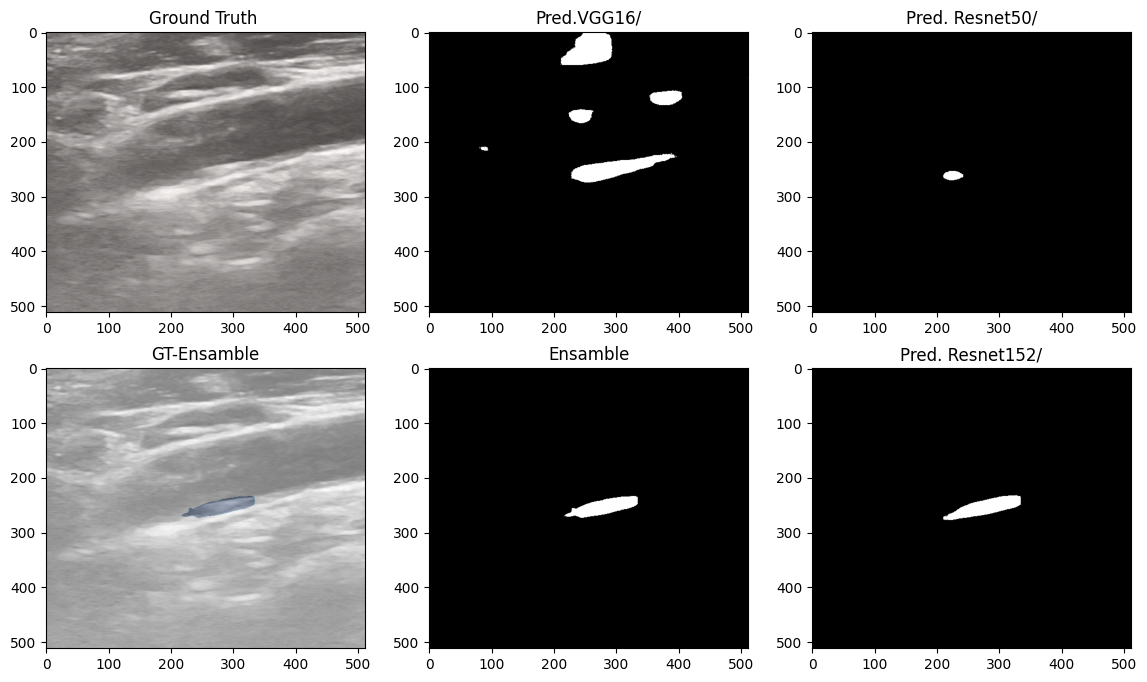

In [ ]:
item = random.randint(0, len(images_test)-1)
item = 15
monocroma=X_test[item]
etiqueta=Y_test[item]
red1=preds[item,:,:,0]
red2=preds[item,:,:,1]
red3=preds[item,:,:,2]
print('imagen'+test_ids[item])
print('imagen item = '+ str(item))

model_comparac_3(monocroma, etiqueta, red1 ,red2, red3, ensamble[item])
print('Jaccard:', jacard_coef_np(Y_test[item], ensamble[item]))
print('DICE:',dice_coef_np(Y_test[item], ensamble[item]))

fname=path_modelo+'resultado_imagen_Test_'+test_ids[item]
plt.savefig(fname)


In [ ]:
for item in range(len(images_test)):
  monocroma=X_test[item]
  etiqueta=Y_test[item]
  red1=preds[item,:,:,0]
  red2=preds[item,:,:,1]
  red3=preds[item,:,:,2]
  model_comparac_3(monocroma, etiqueta, red1 ,red2, red3,ensamble[item],titulo=test_ids[item])
  fname=path_modelo+'resultado_imagen_Test_'+test_ids[item]
  plt.savefig(fname)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print('Global')
print('Jaccard:',jacard_coef_np(Y_test, ensamble))
print('DICE:',dice_coef_np(Y_test, ensamble))

Global
Jaccard: 0.460300772644251
DICE: 0.6304183375669972


In [ ]:
n=len(images_test)
D=0.0
J=0.0
for item in range(n):
  J=J+jacard_coef_np(Y_test[item], ensamble[item])
  D=D+dice_coef_np(Y_test[item], ensamble[item])

J=J/20
D=D/20

print('Promedio')
print('Jaccard:',J)
print('DICE:',D)


Promedio
Jaccard: 1.063823096988159
DICE: 1.2232784286023979


In [ ]:
print(len(preds.shape))
print(ensamble.shape)

4
(48, 512, 512)


### Cálculo de coeficientes test

In [ ]:
Coeficientes_test=np.zeros((len(images_test),8))

Coeficientes_test[:,0:3]=calc_coefs_Jaccard(Y_test, preds) #Jac_modelos
Coeficientes_test[:,3]=calc_coefs_Jaccard(Y_test, ensamble) #Jac_ensamble


Coeficientes_test[:,4:7]=calc_coefs_DICE(Y_test, preds)#DSC_modelos
Coeficientes_test[:,7]=calc_coefs_DICE(Y_test, ensamble) #DSC_ensamble

Coeficientes_test=np.round(Coeficientes_test,4)

### Conteo de falsos positivos,
sumamos el área de placa predicha (en pixeles) en donde no había placa en el GT

In [ ]:
preds_p_sin_placa=preds[placa_test==0].astype('int64')
ensamble_p_sin_placa=ensamble[placa_test==0].astype('int64')

suma_test=np.zeros((len(preds[placa_test==0]),4))

suma_test[:,0:3]=np.sum(preds_p_sin_placa,axis=(1,2)) #suma de falsos positivosp_modelos
suma_test[:,3]=np.sum(ensamble_p_sin_placa, axis=(1,2)) #suma_ensamble

## Data frame

In [ ]:
import pandas as pd

In [ ]:
# Creación de DataFrame:
df_test= pd.DataFrame(Coeficientes_test,index=test_ids, columns=['Jac_modA','Jac_modB','Jac_modC','Jac_ensamble','DSC_modA','DSC_modB','DSC_modC','DSC_ensamble'])
df_test['placa']=placa_test
df_cp_test=df_test[placa_test==1]
# Creación de DataFrame:
df_sp_test= pd.DataFrame(suma_test,index=test_sp_ids, columns=['pred_modA','pred_modB','pred_modC','pred_ensamble'])


In [ ]:
#otra opción
#df_cp_test= pd.DataFrame(Coeficientes_test[placa_test==1],index=test_cp_ids, columns=['Jac_modA','Jac_modB','Jac_modC','Jac_ensamble','DSC_modA','DSC_modB','DSC_modC','DSC_ensamble'])

In [ ]:
# Guarda datos en CSV:
df_cp_test.to_csv(path_modelo+'coefic_test_cp.csv')#, header=False, index=False)
df_sp_test.to_csv(path_modelo+'coefic_test_sp.csv')
# Guardar el DataFrame como un archivo Excel
df_cp_test.to_excel(path_modelo + 'coefic_test_cp.xlsx', index=False)
df_sp_test.to_excel(path_modelo + 'coefic_test_sp.xlsx', index=False)

In [ ]:
df_cp_test.head()

,Jac_modA,Jac_modB,Jac_modC,Jac_ensamble,DSC_modA,DSC_modB,DSC_modC,DSC_ensamble,placa
521.png,0.3452,0.0002,0.7147,0.4338,0.5132,0.0002,0.8336,0.6051,1
523.png,0.3295,0.2157,0.4669,0.3423,0.4956,0.3548,0.6366,0.5100,1
522.png,0.4458,0.4868,0.6144,0.5706,0.6167,0.6548,0.7612,0.7266,1
524.png,0.0589,0.6712,0.1700,0.2065,0.1111,0.8032,0.2904,0.3421,1
528.png,0.1470,0.4266,0.1688,0.1467,0.2562,0.5981,0.2888,0.2558,1


In [ ]:
df_sp_test.head()
df_sp_test

,pred_modA,pred_modB,pred_modC,pred_ensamble
499.png,4.0,593.0,2476.0,1.0
497.png,2541.0,0.0,0.0,0.0
498.png,2243.0,0.0,0.0,0.0
504.png,7524.0,0.0,5520.0,1891.0
500.png,1764.0,382.0,584.0,522.0
501.png,2539.0,1665.0,567.0,1204.0
505.png,9263.0,0.0,2845.0,2457.0
503.png,606.0,1452.0,132.0,0.0
502.png,708.0,0.0,1.0,0.0
509.png,1936.0,34.0,3724.0,341.0


ver: [Matplotlib](https://matplotlib.org/)

**Tabla Símbolo- Color**

“b”	Azul;
“g”	Verde;
“r”	Rojo, etc.; 'c' as cyan;
'm' as magenta;
'y' as yellow;
'k' as black;
'w' as white

https://matplotlib.org/stable/tutorials/colors/colors.html

**Símbolo-	Descripción**

“-“	Línea continua;
“–”	Línea a trazos

“-.”	Línea a puntos y rayas;
“o”	Símbolo círculo relleno

“v”	Símbolo triángulo hacia abajo;
“*”	Símbolo estrella, etc.

ver: [Pyplot de Matplotlib - plt](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)

##graficos comparación Jaccard

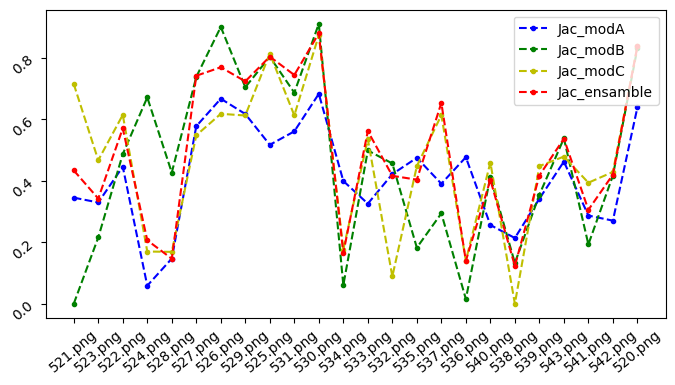

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(df_cp_test.Jac_modA,'b--.') #'rd',x, x3,'g^',
plt.plot(df_cp_test.Jac_modB,'g--.')# en color verde con guiones y punto
plt.plot(df_cp_test.Jac_modC,'y--.') #'rd',x, x3,'g^',
plt.plot(df_cp_test.Jac_ensamble,'r--.')# en color verde con guiones y punto diamante
plt.gca().legend(('Jac_modA','Jac_modB','Jac_modC','Jac_ensamble'),loc='upper right')
plt.tick_params(labelrotation=40)
#plt.show()
fname=path_modelo+'Jaccard_Test_A_B_C_Ensamble'
#plt.savefig(fname)
plt.show()

<Figure size 800x1000 with 0 Axes>

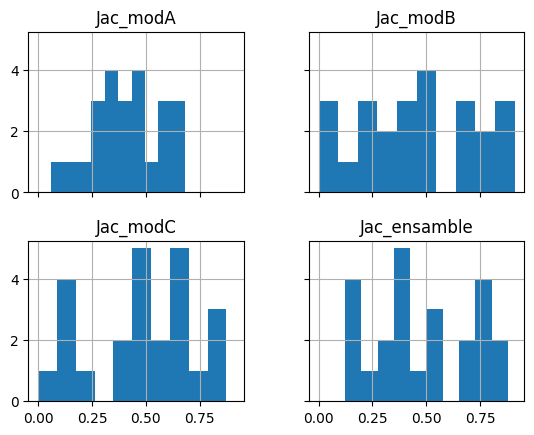

In [ ]:
plt.figure(figsize=(8,10))
col=['Jac_modA','Jac_modB','Jac_modC','Jac_ensamble']
##col=['DSC_modA','DSC_modB','DSC_modC','DSC_ensamble']
df_cp_test.hist(column=col, by=None, grid=True, xlabelsize=None, xrot=None, ylabelsize=None, yrot=None, ax=None, sharex=True, sharey=True, figsize=None, layout=None, bins=10, backend=None, legend=False)#[source]

fname=path_modelo+'Histogr_Jac_Test'
plt.savefig(fname)
plt.show()

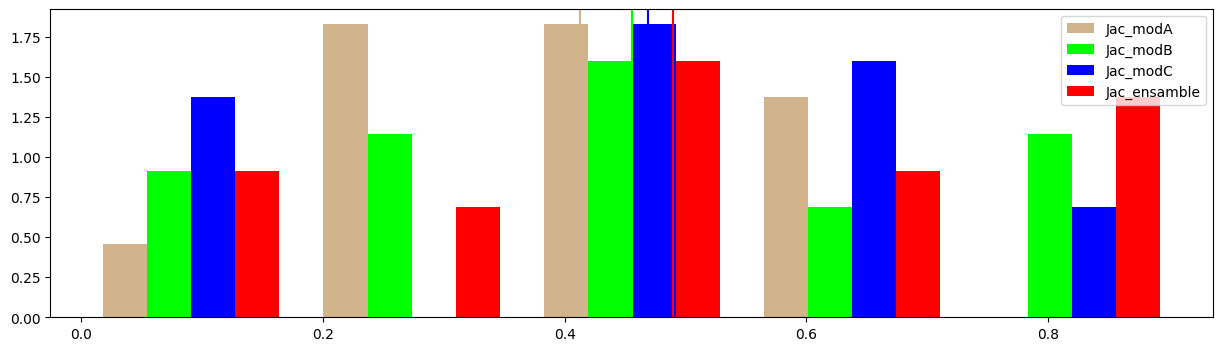

In [ ]:
n_bins = 5
med=df_cp_test.mean()
cols=['Jac_modA','Jac_modB','Jac_modC','Jac_ensamble']

plt.figure(figsize=(15,4))
colors = ['tan', 'lime','blue','red']

plt.hist(df_cp_test[cols], n_bins, density=True, histtype='bar', color=colors, label=colors)
plt.gca().legend(('Jac_modA','Jac_modB','Jac_modC','Jac_ensamble'))#,loc='upper right')

for i in range(4):
  plt.axvline(x=med[cols[i]], color=colors[i])

fname=path_modelo+'Histogr_con_media_Jacc_A_B_C_Ensamble'
plt.savefig(fname)
plt.show()

##graficos comparación DICE

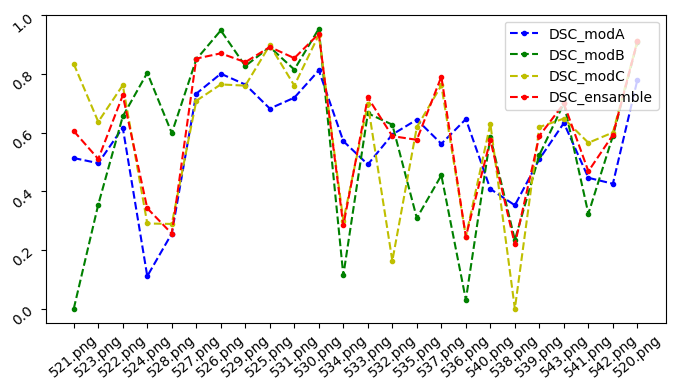

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(df_cp_test.DSC_modA,'b--.') #'rd',x, x3,'g^',
plt.plot(df_cp_test.DSC_modB,'g--.')# en color verde con guiones y punto
plt.plot(df_cp_test.DSC_modC,'y--.') #'rd',x, x3,'g^',
#plt.plot(df.DSC_mod4,'c--.')# en color verde con guiones y punto diamante
plt.plot(df_cp_test.DSC_ensamble,'r--.')# en color verde con guiones y punto diamante
plt.gca().legend(('DSC_modA','DSC_modB','DSC_modC','DSC_ensamble'),loc='upper right')
plt.tick_params(labelrotation=40)

fname=path_modelo+'DICE_Test_A_B_C_Ensamble'
plt.savefig(fname)
plt.show()

<Figure size 800x1000 with 0 Axes>

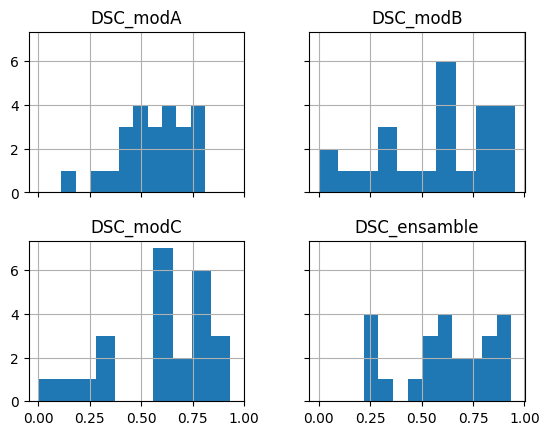

In [ ]:
plt.figure(figsize=(8,10))
#col=['Jac_modA','Jac_modB','Jac_modC','Jac_ensamble']
col=['DSC_modA','DSC_modB','DSC_modC','DSC_ensamble']
df_cp_test.hist(column=col, by=None, grid=True, xlabelsize=None, xrot=None, ylabelsize=None, yrot=None, ax=None, sharex=True, sharey=True, figsize=None, layout=None, bins=10, backend=None, legend=False)#[source]

fname=path_modelo+'Histogr_DSC_Test'
plt.savefig(fname)
plt.show()

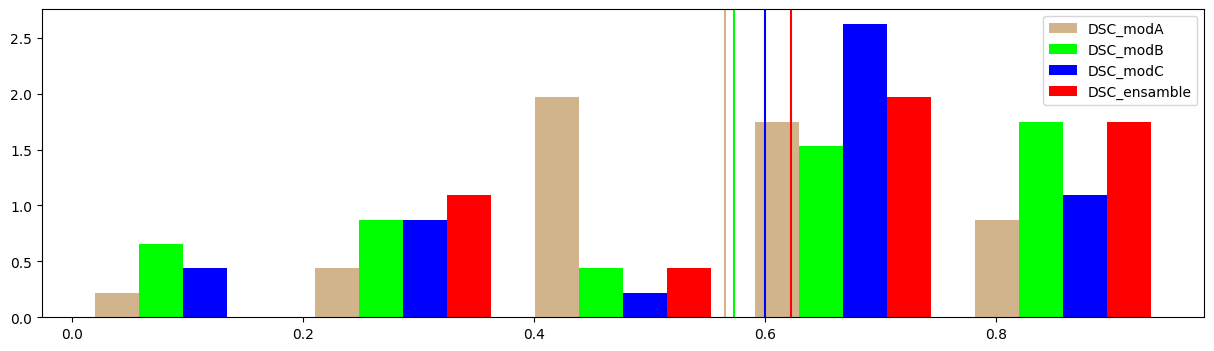

In [ ]:
n_bins = 5
med=df_cp_test.mean()
cols=['DSC_modA','DSC_modB','DSC_modC','DSC_ensamble']

plt.figure(figsize=(15,4))
colors = ['tan', 'lime','blue','red']
plt.hist(df_cp_test[cols], n_bins, density=True, histtype='bar', color=colors, label=colors)
plt.gca().legend(('DSC_modA','DSC_modB','DSC_modC','DSC_ensamble'))#,loc='upper right')


for i in range(4):
  plt.axvline(x=med[cols[i]], color=colors[i])

fname=path_modelo+'Histogr_con_media_DSC_A_B_C_Ensamble'
plt.savefig(fname)
plt.show()

In [ ]:
df_cp_test[['DSC_modA','DSC_modB','DSC_modC','DSC_ensamble']]

,DSC_modA,DSC_modB,DSC_modC,DSC_ensamble
521.png,0.5132,0.0002,0.8336,0.6051
523.png,0.4956,0.3548,0.6366,0.5100
522.png,0.6167,0.6548,0.7612,0.7266
524.png,0.1111,0.8032,0.2904,0.3421
528.png,0.2562,0.5981,0.2888,0.2558
527.png,0.7323,0.8492,0.7080,0.8517
526.png,0.8002,0.9476,0.7638,0.8696
529.png,0.7634,0.8265,0.7596,0.8395
525.png,0.6816,0.8909,0.8974,0.8912
531.png,0.7186,0.8142,0.7599,0.8533


## gráf. Comparación falsos positivos (FP)

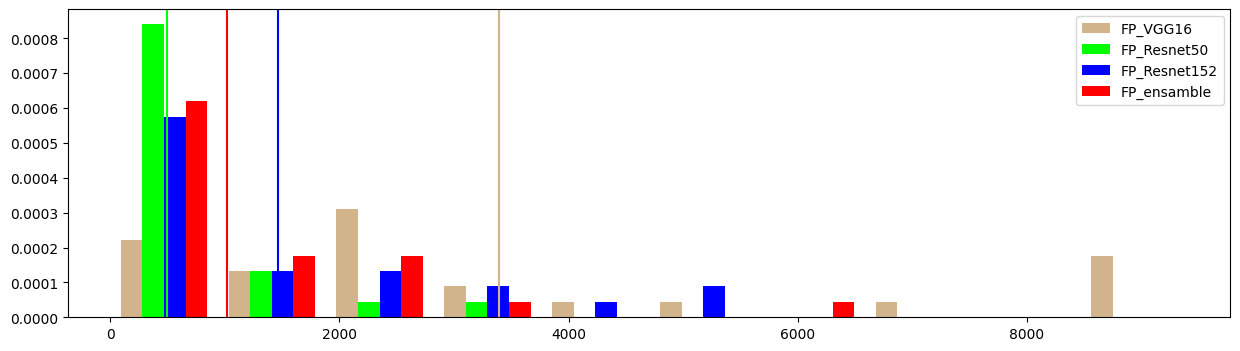

In [ ]:
n_bins = 10
med=df_sp_test.mean()
cols=['pred_modA',	'pred_modB','pred_modC',	'pred_ensamble']

plt.figure(figsize=(15,4))
colors = ['tan', 'lime','blue','red']
plt.hist(df_sp_test, n_bins, density=True, histtype='bar', color=colors, label=colors)
plt.gca().legend(('FP_VGG16','FP_Resnet50','FP_Resnet152','FP_ensamble'))#,loc='upper right')


for i in range(4):
  plt.axvline(x=med[cols[i]], color=colors[i])

fname=path_modelo+'Histograma_FP_con_media_Test_A_B_C_Ensamble'
plt.savefig(fname)
plt.show()

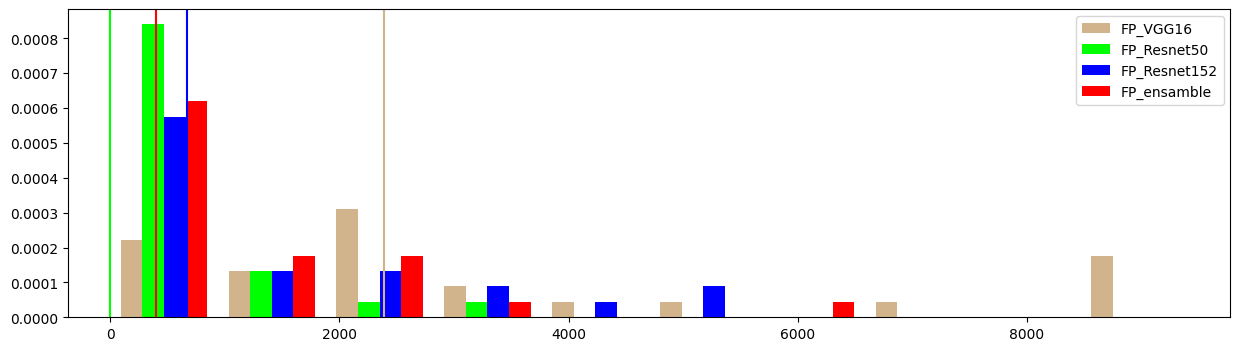

In [ ]:
n_bins = 10
med=df_sp_test.median()
cols=['pred_modA',	'pred_modB','pred_modC',	'pred_ensamble']

plt.figure(figsize=(15,4))
colors = ['tan', 'lime','blue','red']
plt.hist(df_sp_test, n_bins, density=True, histtype='bar', color=colors, label=colors)
plt.gca().legend(('FP_VGG16','FP_Resnet50','FP_Resnet152','FP_ensamble'))#,loc='upper right')


for i in range(4):
  plt.axvline(x=med[cols[i]], color=colors[i])

fname=path_modelo+'Histograma_FP_con_mediana_Test_A_B_C_Ensamble'
plt.savefig(fname)
plt.show()

## Resultados TEST

In [ ]:
print ('50% es la mediana')
df_cp_test.describe().loc[['50%','mean','std']]

50% es la mediana


,Jac_modA,Jac_modB,Jac_modC,Jac_ensamble,DSC_modA,DSC_modB,DSC_modC,DSC_ensamble,placa
50%,0.410550,0.441500,0.472850,0.427000,0.582050,0.612400,0.642050,0.598400,1.0
mean,0.412833,0.455463,0.469229,0.489408,0.565000,0.573100,0.599562,0.622287,1.0
std,0.164545,0.281375,0.241453,0.239797,0.175483,0.289591,0.252526,0.228415,0.0


In [ ]:
df_cp_test.mean()#

Jac_modA        0.412833
Jac_modB        0.455463
Jac_modC        0.469229
Jac_ensamble    0.489408
DSC_modA        0.565000
DSC_modB        0.573100
DSC_modC        0.599563
DSC_ensamble    0.622287
placa           1.000000
dtype: float64

In [ ]:
df_cp_test.std()#

Jac_modA        0.164545
Jac_modB        0.281375
Jac_modC        0.241453
Jac_ensamble    0.239797
DSC_modA        0.175483
DSC_modB        0.289591
DSC_modC        0.252526
DSC_ensamble    0.228415
placa           0.000000
dtype: float64

In [ ]:
df_sp_test.describe()#.loc[['mean','std']]

,pred_modA,pred_modB,pred_modC,pred_ensamble
count,24.000000,24.000000,24.000000,24.000000
mean,3395.041667,500.666667,1465.791667,1022.333333
std,3096.607267,842.839232,1727.120121,1427.467586
min,0.000000,0.000000,0.000000,0.000000
25%,1576.250000,0.000000,0.750000,0.000000
50%,2391.000000,0.000000,673.000000,403.500000
75%,4278.750000,652.500000,2540.750000,1480.000000
max,9408.000000,3144.000000,5520.000000,5661.000000


In [ ]:
print ('50% es la mediana')
df_sp_test.describe().loc[['50%','mean','std']].round()

50% es la mediana


,pred_modA,pred_modB,pred_modC,pred_ensamble
50%,2391.0,0.0,673.0,404.0
mean,3395.0,501.0,1466.0,1022.0
std,3097.0,843.0,1727.0,1427.0


In [ ]:
df_sp_test.median()#

pred_modA        2391.0
pred_modB           0.0
pred_modC         673.0
pred_ensamble     403.5
dtype: float64

In [ ]:
df_sp_test.mean().round(1)#.loc[['mean','std']]

pred_modA        3395.0
pred_modB         500.7
pred_modC        1465.8
pred_ensamble    1022.3
dtype: float64

In [ ]:
#df_cp_test[['Jac_ensamble','Jac_modA']]

## Train

## Predichos para train

In [ ]:

#database_path = os.path.join(path_train, "clean_png_train")#se usaba para base mejorada
database_path = path_train

files_train = os.listdir(database_path)

images_train = [item for item in files_train if 'labeled' not in item]


#random.shuffle(images)

print(f'Total number of Train images: {len(images_train)}')
print(images_train)


train_ids = images_train

Total number of Train images: 493
['201.png', '203.png', '78.png', '45.png', '237.png', '83.png', '96.png', '259.png', '204.png', '47.png', '25.png', '200.png', '91.png', '106.png', '102.png', '202.png', '56.png', '110.png', '146.png', '80.png', '207.png', '206.png', '217.png', '239.png', '231.png', '233.png', '169.png', '175.png', '135.png', '111.png', '223.png', '113.png', '126.png', '229.png', '253.png', '193.png', '15.png', '137.png', '196.png', '2.png', '180.png', '151.png', '213.png', '166.png', '248.png', '228.png', '188.png', '150.png', '211.png', '174.png', '127.png', '161.png', '230.png', '235.png', '214.png', '147.png', '104.png', '152.png', '192.png', '19.png', '244.png', '23.png', '212.png', '183.png', '105.png', '142.png', '222.png', '140.png', '186.png', '13.png', '159.png', '219.png', '14.png', '249.png', '116.png', '252.png', '181.png', '125.png', '250.png', '154.png', '107.png', '148.png', '177.png', '120.png', '179.png', '185.png', '20.png', '241.png', '225.png', '18

In [ ]:
train_images = []
train_masks = []

for image_id in train_ids:

    image_path = os.path.join(database_path, str(image_id))
    train_images.append(image_path)
    mask_path = os.path.join(database_path, image_id.replace(".png","")) + "_labeled.png"
    train_masks.append(mask_path)

In [ ]:
Xtrain = []
Ytrain = []
placa_train = []
train_sp_ids= []
train_cp_ids= []

for image_id in train_ids:

    #print(image_id)

    image_path = os.path.join(database_path, str(image_id))
    mask_path = os.path.join(database_path, image_id.replace(".png","")) + "_labeled.png"
    image = cv2.imread(image_path, 0)
    mask = cv2.imread(mask_path, 0)
    Xtrain.append(image)
    Ytrain.append(mask)
    if np.sum(mask) == 0:
      placa_train.append(0)
      train_sp_ids.append(image_id)

    else:
      placa_train.append(1)
      train_cp_ids.append(image_id)


placa_train = np.asarray(placa_train, dtype=np.uint8)
print('placa:',placa_train.shape)

placa: (493,)


In [ ]:
#armar nueva lista
centro_x= 400
centro_y=400

for r in range(len(train_ids)):
  h,w=Xtrain[r].shape
  imagenvieja=Xtrain[r]

  if h<800 or w<800:
    imagen_auxiliar=np.zeros((800,800),dtype='uint8')
    top_y=(800-h)//2
    left_x=(800-w)//2
    bottom_y = top_y + h
    right_x = left_x+w
    imagen_auxiliar[top_y:bottom_y, left_x:right_x] = imagenvieja
    imagenvieja=imagen_auxiliar


  Xtrain[r]= imagenvieja[144:656, 144:656]# 512x512 centrado


In [ ]:
X_train = np.asarray(Xtrain, dtype=np.uint8)
print('Xtrain:',X_train.shape)



Xtrain: (493, 512, 512)


In [ ]:
#armar nueva lista
centro_x= 400
centro_y=400

for r in range(len(train_ids)):
  h,w=Ytrain[r].shape
  imagenvieja=Ytrain[r]

  if h<800 or w<800:
    imagen_auxiliar=np.zeros((800,800),dtype='uint8')
    top_y=(800-h)//2
    left_x=(800-w)//2
    bottom_y = top_y + h
    right_x = left_x+w
    imagen_auxiliar[top_y:bottom_y, left_x:right_x] = imagenvieja
    imagenvieja=imagen_auxiliar


  Ytrain[r]= imagenvieja[144:656, 144:656]# 512x512 centrado

In [ ]:
Y_train = np.asarray(Ytrain, dtype=bool)
print('Ytrain:',Y_train.shape)


Ytrain: (493, 512, 512)


In [ ]:
pred_train=np.zeros((len(Y_train),512,512,3))

In [ ]:
pred_train1= TLmodel1.predict(X_train)

16/16 [==============================] - 2695s 168s/step


In [ ]:
pred_train[:,:,:,0]=pred_train1[:,:,:,0] #quito la última dim "ficticia"

In [ ]:
pred_train2= TLmodel2.predict(X_train)

16/16 [==============================] - 1493s 93s/step


In [ ]:
pred_train[:,:,:,1]=pred_train2[:,:,:,0] #quito la última dim "ficticia"

In [ ]:
pred_train3= TLmodel3.predict(X_train)

16/16 [==============================] - 2416s 151s/step


In [ ]:
pred_train[:,:,:,2]=pred_train3[:,:,:,0] #quito la última dim "ficticia"

In [ ]:
result_train = pred_train.copy()
resul_train=pred_train >0.5

pred_train=resul_train
ensamble_t_soft=np.sum(resul_train,3)
ensamble_t=ensamble_t_soft >=2
print(pred_train.shape, ensamble_t.shape)

In [ ]:
item = random.randint(0, len(X_train)-1)
item = 6
monocroma=X_train[item]
etiqueta=Y_train[item]
red1=pred_train[item,:,:,0]
red2=pred_train[item,:,:,1]
red3=pred_train[item,:,:,2]
#red4=pred_train[item,:,:,3]
print('imagen'+train_ids[item])
print('imagen item = '+ str(item))

model_comparac_3(monocroma, etiqueta, red1 ,red2, red3, ensamble_t[item])
print('Jaccard ensamble:', jacard_coef_np(Y_train[item], ensamble_t[item]))
print('DICE ensamble:',dice_coef_np(Y_train[item], ensamble_t[item]))

fname=path_modelo+'resultado_imagen_Train_'+train_ids[item]
plt.savefig(fname)


### Cálculo de coeficientes train

In [ ]:
Coeficientes_train=np.zeros((len(train_ids),8))

Coeficientes_train[:,0:3]=calc_coefs_Jaccard(Y_train, pred_train) #Jac_modelos
Coeficientes_train[:,3]=calc_coefs_Jaccard(Y_train, ensamble_t) #Jac_ensamble


Coeficientes_train[:,4:7]=calc_coefs_DICE(Y_train, pred_train)#DSC_modelos
Coeficientes_train[:,7]=calc_coefs_DICE(Y_train, ensamble_t) #DSC_ensamble


Coeficientes_train=np.round(Coeficientes_train,4)

### Conteo de falsos positivos,
sumamos el área de placa predicha (en pixeles) en donde no había placa en el GT

In [ ]:
preds_p_sin_placa_train=pred_train[placa_train==0].astype('int64')
ensamble_p_sin_placa_train=ensamble_t[placa_train==0].astype('int64')

suma_train=np.zeros((len(preds_p_sin_placa_train),4))

suma_train[:,0:3]=np.sum(preds_p_sin_placa_train,axis=(1,2)) #suma de falsos positivosp_modelos
suma_train[:,3]=np.sum(ensamble_p_sin_placa_train, axis=(1,2)) #suma_ensamble

## Data frame

In [ ]:
import pandas as pd

# Creación de DataFrame:
df_train= pd.DataFrame(Coeficientes_train,index=train_ids, columns=['Jac_modA','Jac_modB','Jac_modC','Jac_ensamble','DSC_modA','DSC_modB','DSC_modC','DSC_ensamble'])
df_train['placa']=placa_train
df_cp_train=df_train[placa_train==1]
# Creación de DataFrame:
df_sp_train= pd.DataFrame(suma_train,index=train_sp_ids, columns=['pred_modA','pred_modB','pred_modC','pred_ensamble'])


In [ ]:
#otra opción
#df_cp_train= pd.DataFrame(Coeficientes_train[placa_train==1],index=test_sp_ids, columns=['Jac_mod1','Jac_mod2','Jac_mod3','Jac_ensamble','DSC_mod1','DSC_mod2','DSC_mod3','DSC_ensamble'])

In [ ]:
# Guarda datos en CSV:
df_cp_train.to_csv(path_modelo+'coefic_train_cp.csv')#, header=False, index=False)
df_sp_train.to_csv(path_modelo+'coefic_train_sp.csv')
# Guardar el DataFrame como un archivo Excel
df_cp_train.to_excel(path_modelo + 'coefic_train_cp.xlsx', index=False)
df_sp_train.to_excel(path_modelo + 'coefic_train_sp.xlsx', index=False)

In [ ]:
df_cp_train.head()

In [ ]:
df_sp_train.head()

## Histogramas comparación

In [ ]:
item = random.randint(0, len(train_ids)-1)
#item = 6
monocroma=X_train[item]
etiqueta=Y_train[item]

print('imagen'+train_ids[item])
print('imagen item = '+ str(item))
red1=pred_train[item,:,:,0]
red2=pred_train[item,:,:,1]
red3=pred_train[item,:,:,2]

model_comparac_3(monocroma, etiqueta, red1 ,red2, red3, ensamble_t[item])
print('Medidas:  Ensamble')
print('Jaccard:', np.round(jacard_coef_np(Y_train[item], ensamble_t[item]),4))
print('DICE:',np.round(dice_coef_np(Y_train[item], ensamble_t[item]),4))

In [ ]:
plt.figure(figsize=(15,4))

plt.plot(df_cp_train.Jac_modA,'b--.') #'rd',x, x3,'g^',
plt.plot(df_cp_train.Jac_modB,'g--.')# en color verde con guiones y punto
plt.plot(df_cp_train.Jac_modC,'y--.') #'rd',x, x3,'g^',
#plt.plot(df_train.Jac_mod4,'c--.')# en color verde con guiones y punto diamante
plt.plot(df_cp_train.Jac_ensamble,'r--.')# en color verde con guiones y punto diamante
plt.gca().legend(('Jac_modA','Jac_modB','Jac_modC','Jac_ensamble'),loc='upper right')
plt.tick_params(labelrotation=40)
#plt.show()
fname=path_modelo+'Jaccard_Train_A_B_C_Ensamble'
plt.savefig(fname)

In [ ]:
n_bins = 10

plt.figure(figsize=(15,4))
colors = ['tan', 'lime','blue','red']
plt.hist(df_sp_train, n_bins, density=True, histtype='bar', color=colors, label=colors)
plt.gca().legend(('FP_modA','FP_modB','FP_modC','FP_ensamble'))#,loc='upper right')
#plt.tick_params(labelrotation=40)

fname=path_modelo+'Histograma_FP_Train_A_B_C_Ensamble'
plt.savefig(fname)
plt.show()